In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#trajectory3: delta = .40
#trajectory1: delta = .05 
#trajectory2: delta= .05, tau=5
#trajectory_Ldist_tau500_phi01_eps01
traj = np.load('trajs/trajectory_voter_full_tau100') #  trajectory_Ldist_tau5_phi01_eps01_fully
delta=5
tau=100

In [2]:
N=100
size = 80000#len(traj.index)
S = np.zeros(shape=(size, N))
K = np.zeros(shape=(size, N))
C = np.zeros(shape=(size, N))
w = np.zeros(shape=(size, 1))
r = np.zeros(shape=(size,1))
L = traj['P'][0]
y = np.zeros(shape=(size,1))
idx = traj.index[0:size]
for a, t in enumerate(traj.index[0:size]):
    S[a,:] = traj['s'][t]
    C[a,:] = traj['C'][t]
    K[a,:] = traj['capital'][t]
    w[a,:] = traj['wage'][t]
    r[a,:] = traj['r'][t]
    y[a,:] = traj['Y'][t]
del traj
        


20123.8499017


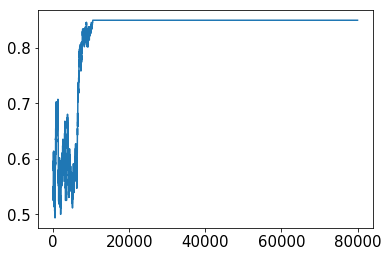

In [6]:
plt.plot(S.mean(1))
print idx[20000]

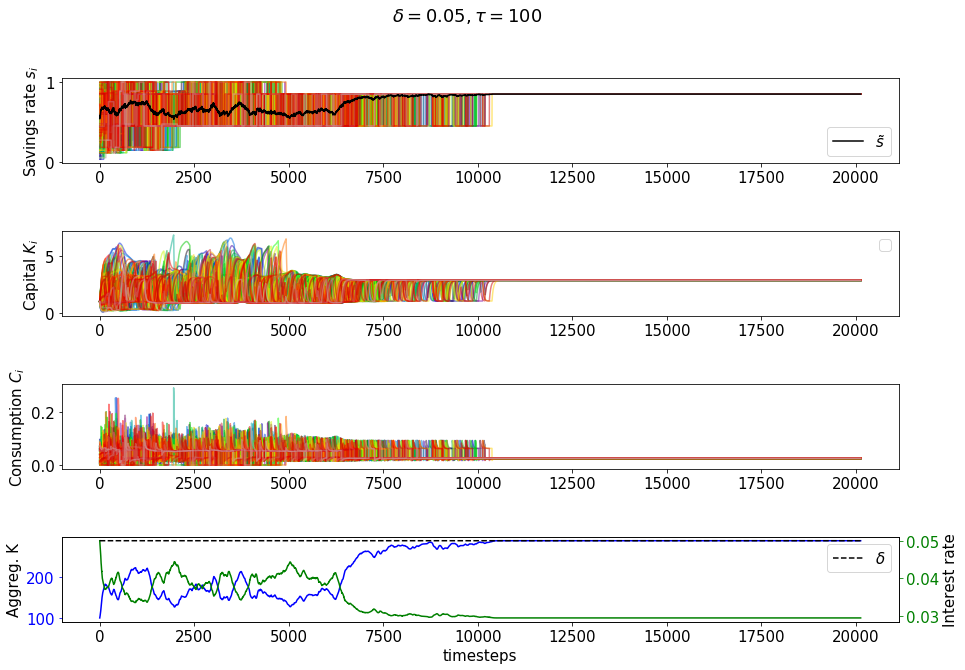

In [5]:
plt.rc('font', size=15)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(15,10))
plt.suptitle(r'$\delta=%s, \tau=%s$'%(np.round(delta/100.,2),tau))
fig.subplots_adjust(hspace = .8, wspace=.01);

start, stop = 0, 20000#len(idx) - 250,len(idx) 
Lim=4
grou=  range(100) #[20,24,70]

nag = len(grou)+1

sincome = S[start:stop,:]* (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])

income = (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])


for a,i in enumerate(grou):
    ax1.plot(idx[start:stop],S[start:stop,i], 
             c=plt.cm.spectral(float(a+1) / nag), alpha=.5)#label='Househ. %s'%a)
    ax1.set_ylabel(r'Savings rate $s_i$')
    
    ax2.plot(idx[start:stop],K[start:stop,i],#income[i], 
             c=plt.cm.spectral(float(a+1) / nag),alpha=.5)
    ax2.set_ylabel(r'Capital $K_i$')
    ax3.plot(idx[start:stop],C[start:stop,i], 
             c=plt.cm.spectral(float(a+1) / nag),alpha=.5)
    ax3.set_ylabel(r'Consumption $C_i$')


ax1.plot(idx[start:stop],(sincome.sum(1) / income.sum(1)),'k',
            label=r'$\tilde{s}$')   
ax1.legend()
ax3.legend()


from collections import OrderedDict
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=2)

ax4.plot(idx[start:stop],K[start:stop,:].sum(1),c='b');
ax4.set_ylabel('Aggreg. K')

ax5 = ax4.twinx();
ax5.plot(idx[start:stop],r[start:stop],c='g');
ax5.plot(idx[start:stop],delta/100. +0*idx[start:stop],
         'k--',label=r'$\delta$');

ax5.legend(loc='upper right')
ax5.set_ylabel('Interest rate')
ax5.tick_params(axis='y', colors='g')
ax4.tick_params(axis='y', colors='b')
ax4.set_xlabel('timesteps')
fig.savefig('voter_delta_%s_start%s_stop%s_eps01_phi01_all_tau100.pdf'%(delta,start,stop))


In [ ]:
#################### Phaseplane plots ##################################
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import colors, ticker
from scipy.optimize import root, fsolve,brentq,minimize,fminbound
%matplotlib inline
import scipy.integrate as integrate
u = np.linspace(1e-9, 1.-1e-9, 200) # savings rate
rs = np.linspace(0.00,0.1,200)
SS, R = np.meshgrid(u, rs)
plt.rc('font', size=20)


li= .01
delta = 0.05
k0=0. 
tau=500.

def c_hat(s,rr):
    D = rr - delta/s
    ww = 0.25/rr
    A = (rr*k0 + ww*li*rr/D ) *np.exp(s*D*tau)
    
    B = ww*li*(1. - rr/D)
    return (1. - s)* (A+B)

def c_hat_neg(s):
    return -c_hat(s,rr)

Z=SS.copy()
for a,rr in enumerate(rs):
    for b, s in enumerate(u):
        Z[a,b]= c_hat(s,rr)
sroot=[]
for rr in rs:
    sroot.append(fminbound(c_hat_neg,1e-7,1., maxfun=40000,xtol=1e-12 ))
    
fig2=plt.figure(figsize=(13,8))
ax=fig2.add_subplot(111)

k0=0
def f(Y, t):
    s, rr = Y
    D = rr- delta/s
    ww= 0.25/rr
    gamma = k0*rr*D + ww *li*rr
    A = s*gamma*np.exp(D*s*tau)* (1. - (1.-s)*rr*tau) - delta*ww*li
    B = (1.-s)*(1- np.exp(D*s*tau))*(rr*ww*li*delta/(s*D))
    sdot = np.sign(A-B)/tau 
    kk = 1./(4*rr*rr) +k0*10
    rdot =  -s*rr*rr +delta*rr/2.
    return [sdot, rdot]

s1 = np.linspace(.0,1. , 100)
r2 = np.linspace(.0, .1, 100)

S1, R2 = np.meshgrid(s1, r2)

u, v = np.zeros(S1.shape), np.zeros(R2.shape)

NI, NJ = S1.shape

for i in range(NI):
    for j in range(NJ):
        x = S1[i, j]
        y = R2[i, j]
        yprime = f([x, y], t)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]

ax.streamplot(S1, R2, u, v,color=plt.cm.spectral(1./ 4),density=1.2,arrowsize=2) #np.sign(v)*np.exp(v)
       
start, stop = 30500, 31000#,20000 
sincome = S[start:stop,:]* (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])

income = (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])



ax.plot(sincome.sum(1)/income.sum(1), r[start:stop],c='g',label=r'$r(\tilde{s})$')
ax.plot(np.linspace(0,1,100), 0.05/(2*np.linspace(0,1,100)),'k',label=r'$\dot{r}=0$')
ax.plot(sroot,rs,'ko-',label=r'$\dot{s}=0,K_0=0$')

ll= ax.legend(ncol=1,loc='upper right');#frame= ll.get_frame();frame.set_facecolor('tan');frame.set_edgecolor('black')
ax.set_ylabel(r'$r$')
ax.set_xlabel(r'$\tilde{s}$')
ax.set_ylim((0.035,0.09))
ax.set_xlim((0,1.))
ax.set_aspect('auto')
ax.set_title(r'$\tau=$%s'%int(tau))
#fig2.savefig('phase_500_%s_%s.pdf'%(start,stop))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import colors, ticker
from scipy.optimize import root, fsolve,brentq,minimize,fminbound
%matplotlib inline
import scipy.integrate as integrate
u = np.linspace(1e-9, 1.-1e-9, 200) # savings rate

rs = np.linspace(0.01,0.4,200)
SS, R = np.meshgrid(u, rs)
plt.rc('font', size=20)

li= .01
delta = 0.05
k0=0. 
tau=5.


def c_hat(s,rr):
    D = rr - delta/s
    ww = 0.25/rr
    A = (rr*k0 + ww*li*rr/D ) *np.exp(s*D*tau)
    
    B = ww*li*(1. - rr/D)
    return (1. - s)* (A+B)

def c_hat_neg(s):
    return -c_hat(s,rr)

Z=SS.copy()
for a,rr in enumerate(rs):
    for b, s in enumerate(u):
        Z[a,b]= c_hat(s,rr)
sroot=[]
for rr in rs:
    sroot.append(fminbound(c_hat_neg,1e-7,1., maxfun=40000,xtol=1e-12 ))

fig2=plt.figure(figsize=(13,8))
ax=fig2.add_subplot(111)


k0=0
def f(Y, t):
    s, rr = Y
    D = rr- delta/s
    ww= 0.25/rr
    gamma = k0*rr*D + ww *li*rr
    A = s*gamma*np.exp(D*s*tau)* (1. - (1.-s)*rr*tau) - delta*ww*li
    B = (1.-s)*(1- np.exp(D*s*tau))*(rr*ww*li*delta/(s*D))
    sdot = 0.01*np.sign(A-B)/tau 
    kk = 1./(4*rr*rr) +k0*10
    rdot =  -s*rr*rr +delta*rr/2.
    return [sdot, rdot]

s1 = np.linspace(.0,0.2, 100)
r2 = np.linspace(.15, .4, 100)

S1, R2 = np.meshgrid(s1, r2)

u, v = np.zeros(S1.shape), np.zeros(R2.shape)

NI, NJ = S1.shape

for i in range(NI):
    for j in range(NJ):
        x = S1[i, j]
        y = R2[i, j]
        yprime = f([x, y], t)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]

ax.streamplot(S1, R2, u, v,color=plt.cm.spectral(1./ 4),density=1.,arrowsize=2) #np.sign(v)*np.exp(v)
       
start, stop = 15000, 26000#,20000 
sincome = S[start:stop,:]* (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])

income = (r[start:stop] * K[start:stop,:] +\
                            w[start:stop] *L[:])



ax.plot(sincome.sum(1)/income.sum(1), r[start:stop],c='g',label=r'$r(\tilde{s})$')
ax.plot(np.linspace(0,1,100), 0.05/(2*np.linspace(0,1,100)),'k',label=r'$\dot{r}=0$')
ax.plot(sroot,rs,'ko-',label=r'$\dot{s}=0,K_0=0$')
ll= ax.legend(ncol=1,loc='upper right');#frame= ll.get_frame();frame.set_facecolor('tan');frame.set_edgecolor('black')
ax.set_ylabel(r'$r$')
ax.set_xlabel(r'$\tilde{s}$')
ax.set_ylim((0.14,0.4))
ax.set_xlim((0,0.2))
ax.set_aspect('auto')
ax.set_title(r'$\tau=$%s'%int(tau))
fig2.savefig('phase_5_%s_%s.pdf'%(start,stop))